In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# from PIL import Image
pathImage = '/content/gdrive/MyDrive/IPProject/1.jpg'
# pathImage = "1.jpg"
heightImg = 640
widthImg = 480

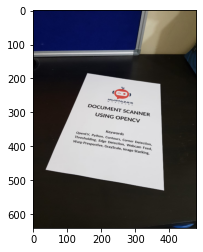

In [ ]:
img = cv2.imread(pathImage)
img = cv2.resize(img, (widthImg, heightImg))  # RESIZE IMAGE
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

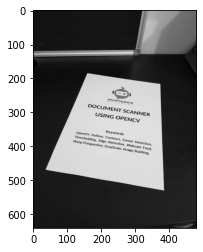

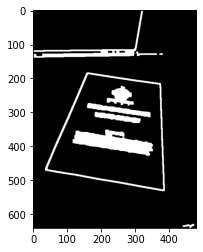

In [ ]:
# Pre-processing steps of the image
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE
plt.imshow(cv2.cvtColor(imgGray, cv2.COLOR_BGR2RGB))
plt.show()

imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  # ADD GAUSSIAN BLUR
imgThreshold = cv2.Canny(imgBlur, 200, 200)  # APPLY CANNY BLUR
kernel = np.ones((5, 5))
# Below steps help remove noise
imgDial = cv2.dilate(imgThreshold, kernel, iterations=2)  # APPLY DILATION
imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION

plt.imshow(cv2.cvtColor(imgThreshold, cv2.COLOR_BGR2RGB))
plt.show()

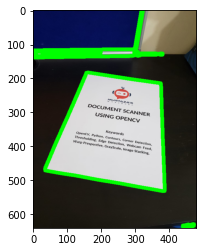

In [ ]:
# Find all contours
imgContours = img.copy()  # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy()  # COPY IMAGE FOR DISPLAY PURPOSES
# RETR_EXTERNAL gives best results if we are trying to find outer methods
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # FIND ALL CONTOURS
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10)  # DRAW ALL DETECTED CONTOURS
plt.imshow(cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 5000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            # check if it is a rectangle by checking if it has 4 edges
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

In [ ]:
def reorder(myPoints):

    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)

    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]

    return myPointsNew

In [ ]:
def drawRectangle(img,biggest,thickness):
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[0][0][0], biggest[0][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[2][0][0], biggest[2][0][1]), (0, 255, 0), thickness)
    cv2.line(img, (biggest[3][0][0], biggest[3][0][1]), (biggest[1][0][0], biggest[1][0][1]), (0, 255, 0), thickness)

    return img

In [ ]:
# FIND THE BIGGEST CONTOUR
biggest, maxArea = biggestContour(contours)  # FIND THE BIGGEST CONTOUR
if biggest.size != 0:
    biggest = reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20)  # DRAW THE BIGGEST CONTOUR
    imgBigContour = drawRectangle(imgBigContour, biggest, 2)
    pts1 = np.float32(biggest)
    # PREPARE POINTS FOR WARP, the 4 points before applying the warp perspective
    pts2 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

    # REMOVE 20 PIXELS FROM EACH SIDE so that bends of paper are removed
    imgWarpColored = imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]
    imgWarpColored = cv2.resize(imgWarpColored, (widthImg, heightImg))

    # APPLY ADAPTIVE THRESHOLD, to get a more paper like field and to convert to black and white
    imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
    # apply below method to get binary image
    imgAdaptiveThre = cv2.adaptiveThreshold(imgWarpGray, 255, 1, 1, 7, 2)
    # Make all 0s 1s and all 1s 0s to get our image
    imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
    # sometimes adaptiveThreshold gives us noise , so we use medianBlur to remove salt and pepper noise
    imgAdaptiveThre = cv2.medianBlur(imgAdaptiveThre, 3)

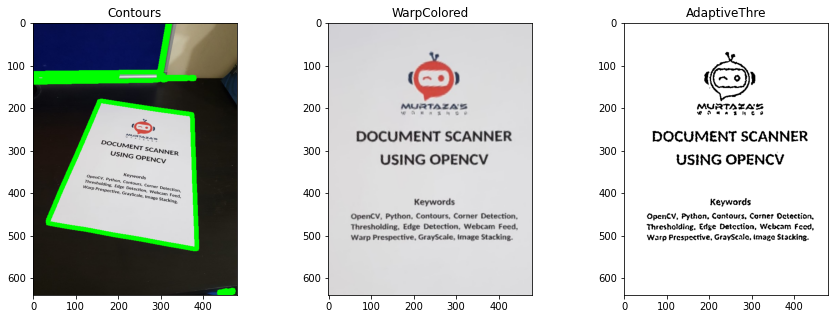

In [ ]:

# Convert color space to RGB
imgContours = cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB)
imgWarpColored = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2RGB)
imgAdaptiveThre = cv2.cvtColor(imgAdaptiveThre, cv2.COLOR_BGR2RGB)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display images
axs[0].imshow(imgContours)
axs[0].set_title('Contours')
axs[1].imshow(imgWarpColored)
axs[1].set_title('WarpColored')
axs[2].imshow(imgAdaptiveThre)
axs[2].set_title('AdaptiveThre')

# Show the subplots
plt.show()